# Lectura y graficación de la señal EMG capturada

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import re

## Abrimos los archivos txt para ver  el contenido

In [3]:
r = open("Datos\ecg_reposo.txt","r")
raw_data = r.readlines()[1]
r.close()
print(raw_data)


# {"98:D3:71:FD:62:1F": {"position": 0, "device": "bitalino_rev", "device name": "98:D3:71:FD:62:1F", "device connection": "BTH98:D3:71:FD:62:1F", "sampling rate": 1000, "resolution": [4, 1, 1, 1, 1, 10], "firmware version": 1282, "comments": "", "keywords": "", "mode": 0, "sync interval": 2, "date": "2023-4-12", "time": "11:41:7.526", "channels": [2], "sensor": ["ECGBIT"], "label": ["A2"], "column": ["nSeq", "I1", "I2", "O1", "O2", "A2"], "special": [{}], "digital IO": [0, 0, 1, 1]}}



In [4]:
## Regex para extraer la frecuencia
x = re.findall("[0-5][0-9][0-9]\d", raw_data)[0]

print(x)

1000


In [5]:
Fs = float(x)
Ts=1/Fs # Determinar el periodo de muestreo

print(f" Fs={Fs} hz\n Ts={Ts} s")

 Fs=1000.0 hz
 Ts=0.001 s


## Leyendo el archivo excluyendo las primeras 3 filas

In [6]:
a_r = np.genfromtxt("Datos\ecg_reposo.txt", delimiter="\t",skip_header = 3)

## Ploteamos la lectura

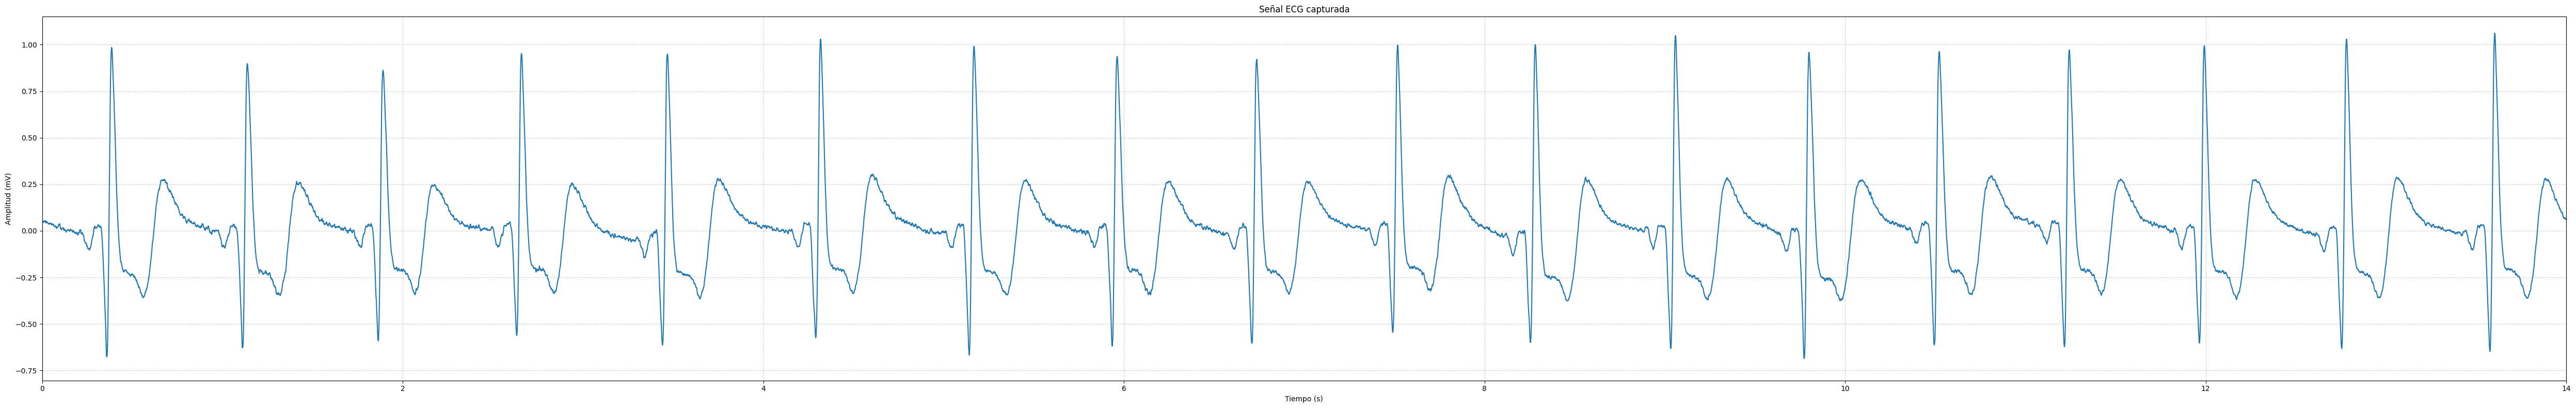

El periodo de la señal en resposo es: 0.72 s, es decir 83.10bpm


In [7]:
import scipy.signal as signal
bits = 10 # Bits de la salida 
volt_range = 3.28 #Rango de voltaje en milivoltios (-1.64; 1.64) mV
# Extraer la penultima columna (datos)
y_1 = (a_r[: ,-2] * volt_range/(2**bits - 1)) # convertir los bits a mV
y_1 = y_1 - np.mean(y_1) # Centrar la señal, ya que va de -1.64 a 1.64
t_1 = np.arange(0, len(y_1)*Ts, Ts) # Crear vector de tiempo considerando periodo de muestreo

plt.figure(figsize=(50, 8))

plt.plot(t_1, y_1, label="señal") # Señal completa
plt.title("Señal ECG capturada");plt.xlim(0, 14)
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)") 
plt.ylabel("Amplitud (mV)")
fig = plt.gcf()
fig.set_facecolor('white')
plt.tight_layout()
#plt.savefig('complete_signal.png', transparent=False, )
plt.show()


pk_loc1 = signal.find_peaks(y_1[int(10.5*Fs):int(12.5*Fs)], height=0.4)[0]
T1 = t_1[pk_loc1[1]] - t_1[pk_loc1[0]]
bpm1 = (1/T1) * 60
print(f"El periodo de la señal en resposo es: {T1:.2f} s, es decir {bpm1:.2f}bpm")

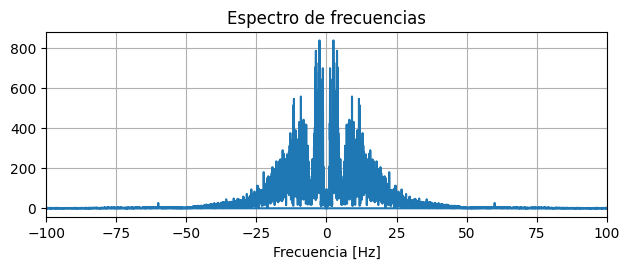

In [8]:
# Calcular la DFT
X = np.fft.fft(y_1)

# Calcular las frecuencias correspondientes
frequencies = np.fft.fftfreq(len(y_1), 1/Fs)

plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(X))
plt.title('Espectro de frecuencias')
plt.xlabel('Frecuencia [Hz]')
plt.grid()

# Establecer límites en el eje x
plt.xlim([-100, 100])

plt.tight_layout()
plt.show()

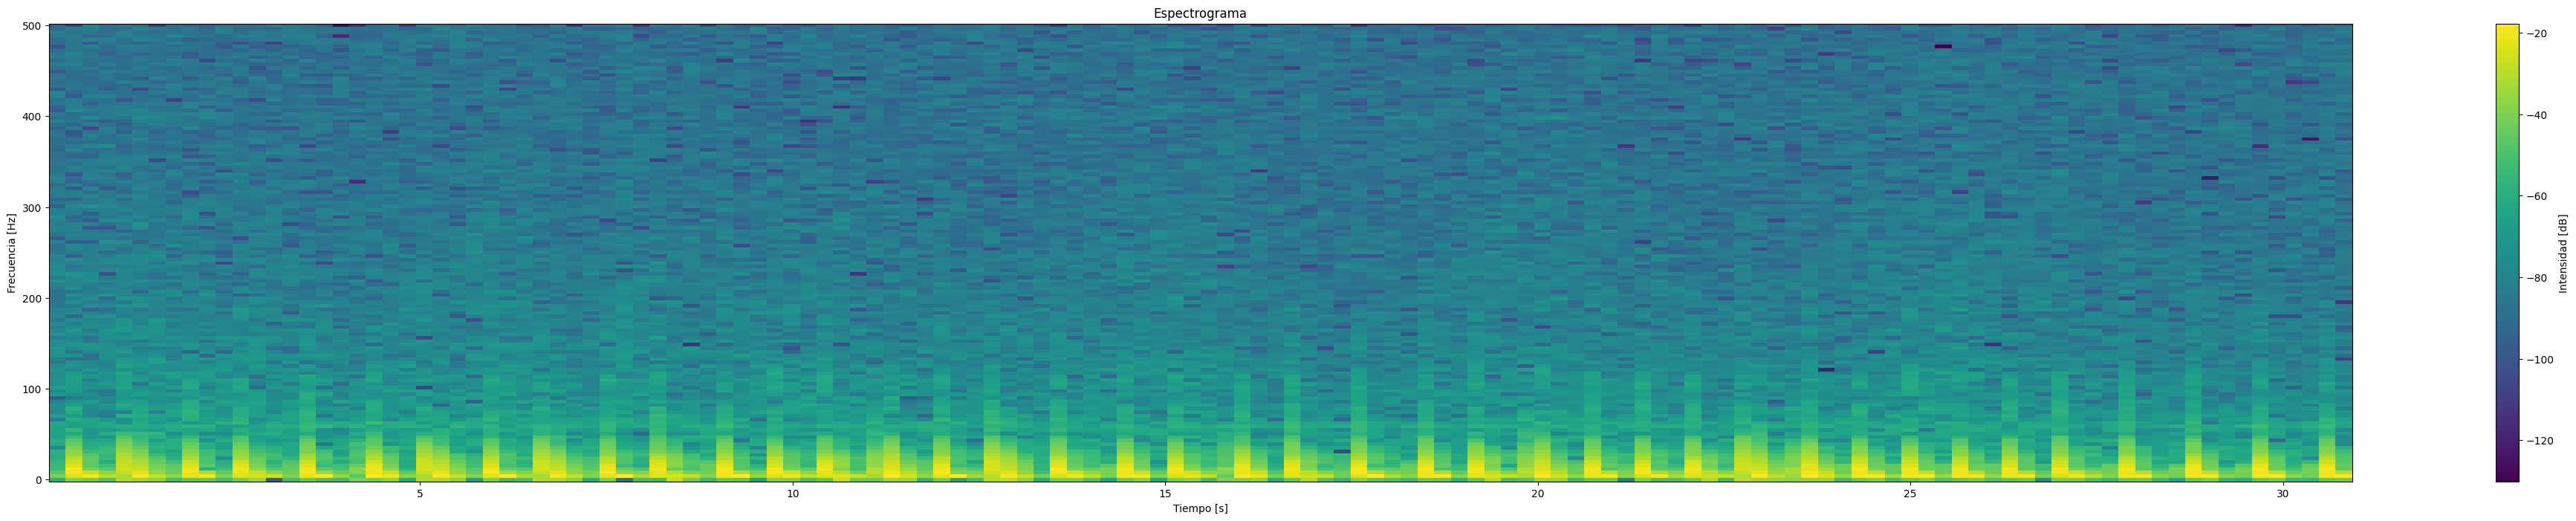

In [9]:
import numpy as np
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Generar una señal de ejemplo (en este caso, una señal senoidal)
fs = 1000  # Frecuencia de muestreo en Hz

# Calcular la STFT
f, t, Sxx = spectrogram(y_1, fs)
plt.figure(figsize=(50, 8))

# Visualizar el espectrograma
plt.pcolormesh(t, f, 10 * np.log10(Sxx))  # Usamos escala logarítmica para mejor visualización
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.title('Espectrograma')
plt.colorbar(label='Intensidad [dB]')
plt.show()


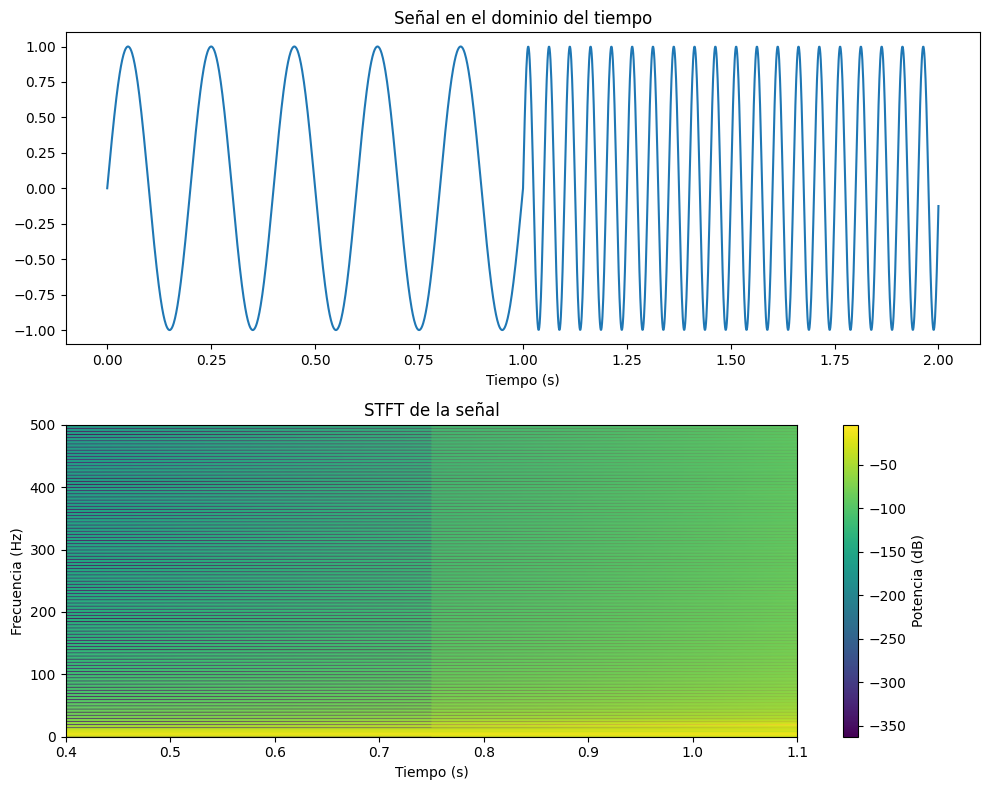

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Generar una señal senoidal con cambio abrupto de frecuencia
t1 = np.linspace(0, 1, 1000, endpoint=False)
t2 = np.linspace(1, 2, 1000, endpoint=False)
x1 = np.sin(2 * np.pi * 5 * t1)  # Frecuencia de 5 Hz
x2 = np.sin(2 * np.pi * 20 * t2)  # Frecuencia de 20 Hz
x = np.concatenate((x1, x2))

# Calcular la STFT con parámetros ajustados
frequencies, times, Sxx = spectrogram(x, fs=1000, nperseg=800)

# Graficar la señal en el dominio del tiempo y su STFT
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, 2, len(x)), x)
plt.title('Señal en el dominio del tiempo')
plt.xlabel('Tiempo (s)')

plt.subplot(2, 1, 2)
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title('STFT de la señal')
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo (s)')
plt.colorbar(label='Potencia (dB)')

plt.tight_layout()
plt.show()


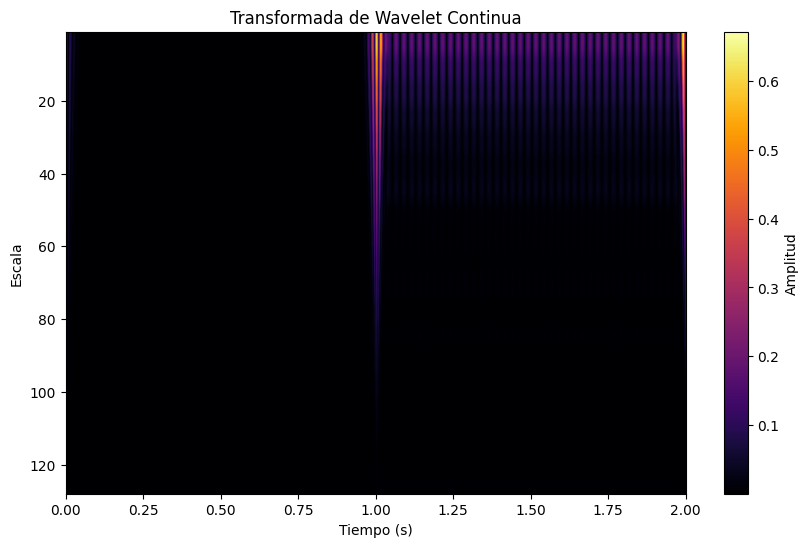

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Generar una señal senoidal con cambio abrupto de frecuencia
t1 = np.linspace(0, 1, 1000, endpoint=False)
t2 = np.linspace(1, 2, 1000, endpoint=False)
x1 = np.sin(2 * np.pi * 5 * t1)  # Frecuencia de 5 Hz
x2 = np.sin(2 * np.pi * 20 * t2)  # Frecuencia de 20 Hz
x = np.concatenate((x1, x2))

# Definir la escala y la frecuencia central de la wavelet de Morlet
escala = np.arange(1, 20)


# Realizar la transformada de wavelet continua
coeficientes, frecuencias = pywt.cwt(x, escala, 'morl', sampling_period=1/1000)

# Graficar los coeficientes de la transformada de wavelet
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coeficientes), extent=[0, 2, 1, 128], aspect='auto', cmap='inferno')
plt.colorbar(label='Amplitud')
plt.title('Transformada de Wavelet Continua')
plt.xlabel('Tiempo (s)')
plt.ylabel('Escala')
plt.gca().invert_yaxis()
plt.show()


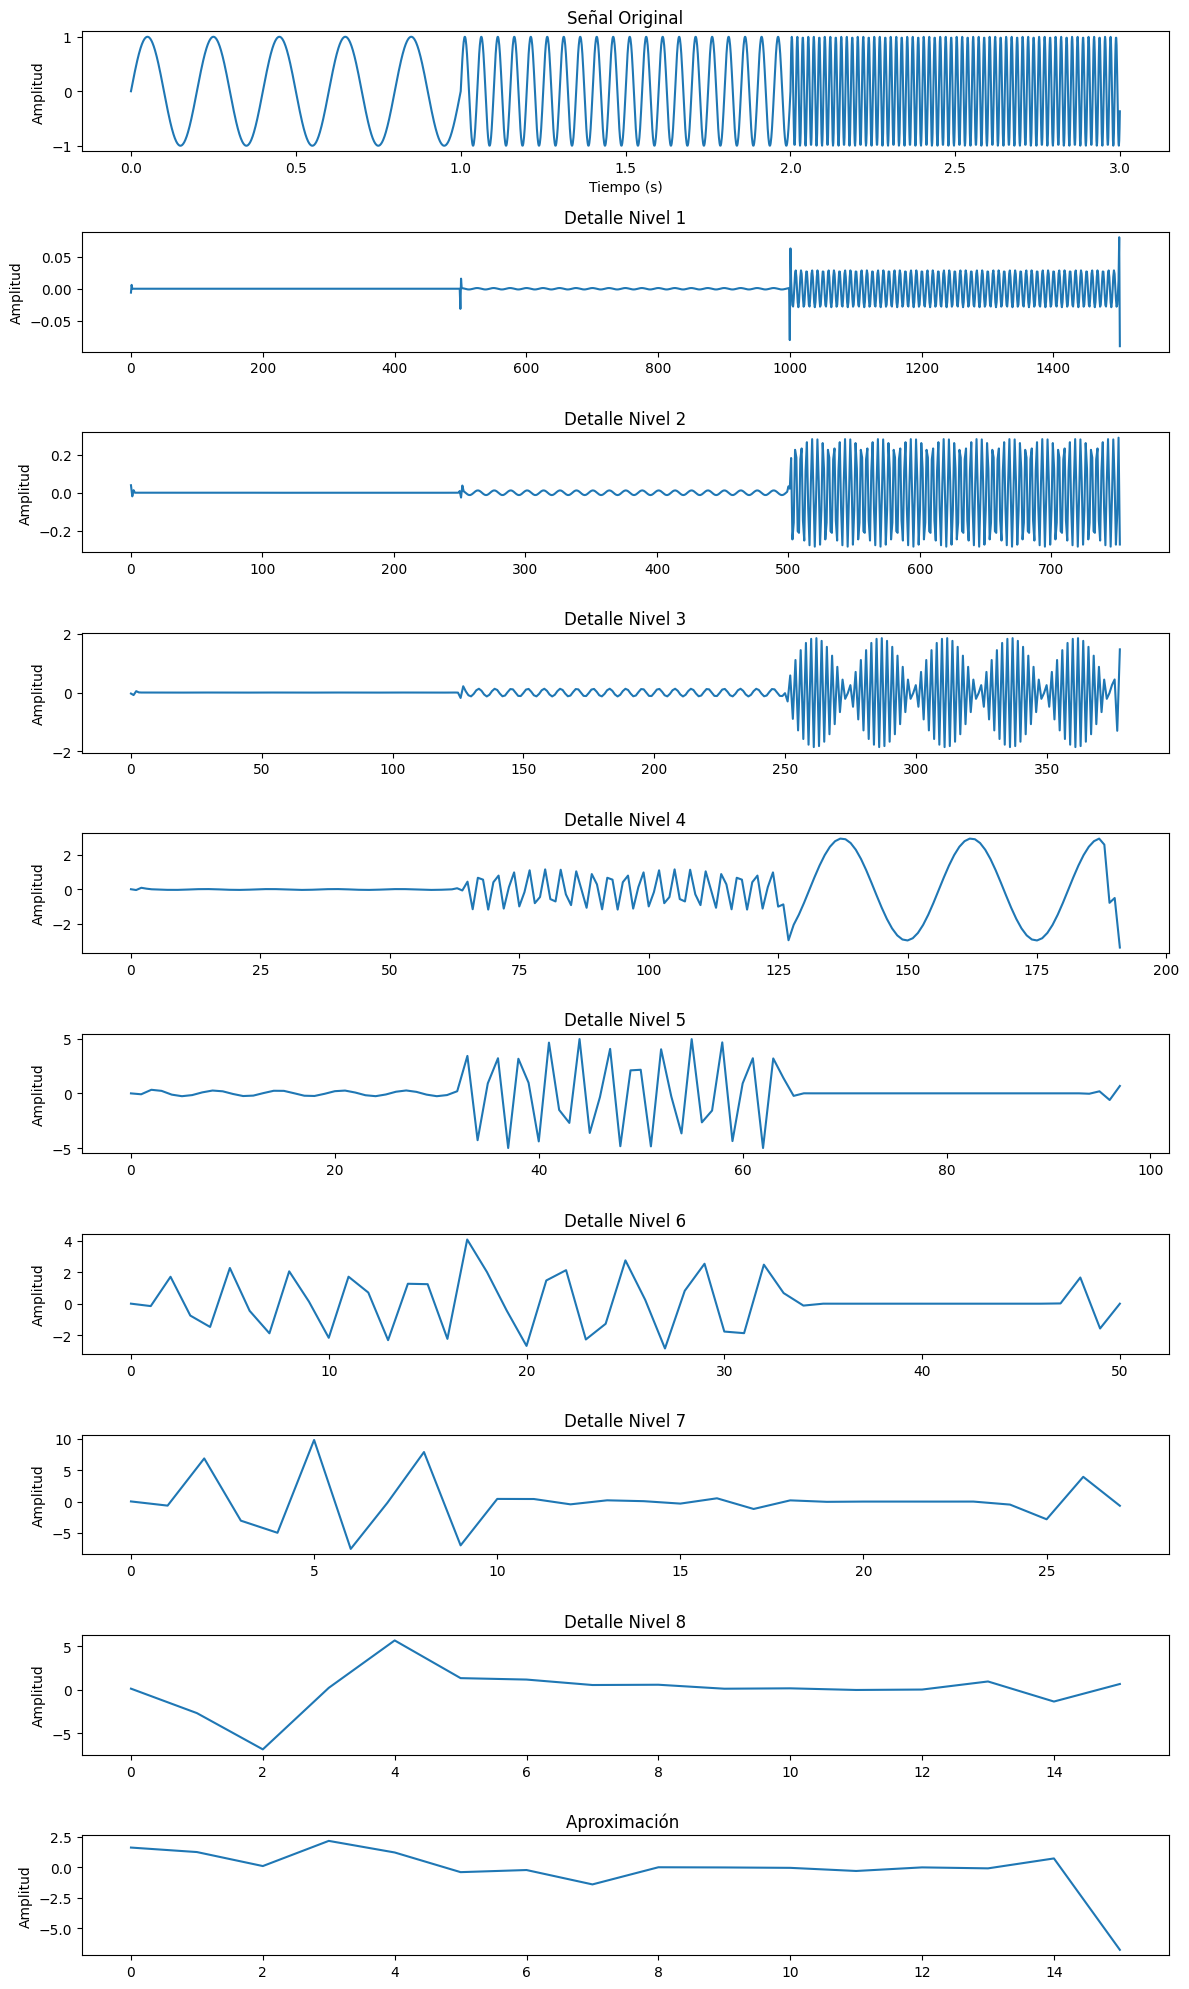

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Generar una señal senoidal con cambios abruptos de frecuencia
t1 = np.linspace(0, 1, 1000, endpoint=False)
t2 = np.linspace(1, 2, 1000, endpoint=False)
t3 = np.linspace(2, 3, 1000, endpoint=False)
x1 = np.sin(2 * np.pi * 5 * t1)  # Frecuencia de 5 Hz
x2 = np.sin(2 * np.pi * 20 * t2)  # Frecuencia de 20 Hz
x3 = np.sin(2 * np.pi * 60 * t3)  # Frecuencia de 60 Hz
x = np.concatenate((x1, x2, x3))

# Aplicar la DWT
niveles = 8
coeficientes = pywt.wavedec(x, 'sym3', level=niveles)

# Graficar la señal original y los coeficientes de detalle y de aproximación
plt.figure(figsize=(12, 20))

# Graficar la señal original
plt.subplot(niveles + 2, 1, 1)
plt.plot(np.concatenate((t1, t2, t3)), x)
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Graficar los coeficientes de detalle en orden ascendente (del nivel 1 al 8)
for i in range(1, niveles + 1):
    plt.subplot(niveles + 2, 1, i + 1)
    plt.plot(coeficientes[niveles - i + 1])
    plt.title(f'Detalle Nivel {i}')
    plt.ylabel('Amplitud')

# Graficar el coeficiente de aproximación al final
plt.subplot(niveles + 2, 1, niveles + 2)
plt.plot(coeficientes[0])
plt.title(f'Aproximación ')
plt.ylabel('Amplitud')

plt.tight_layout()
plt.show()

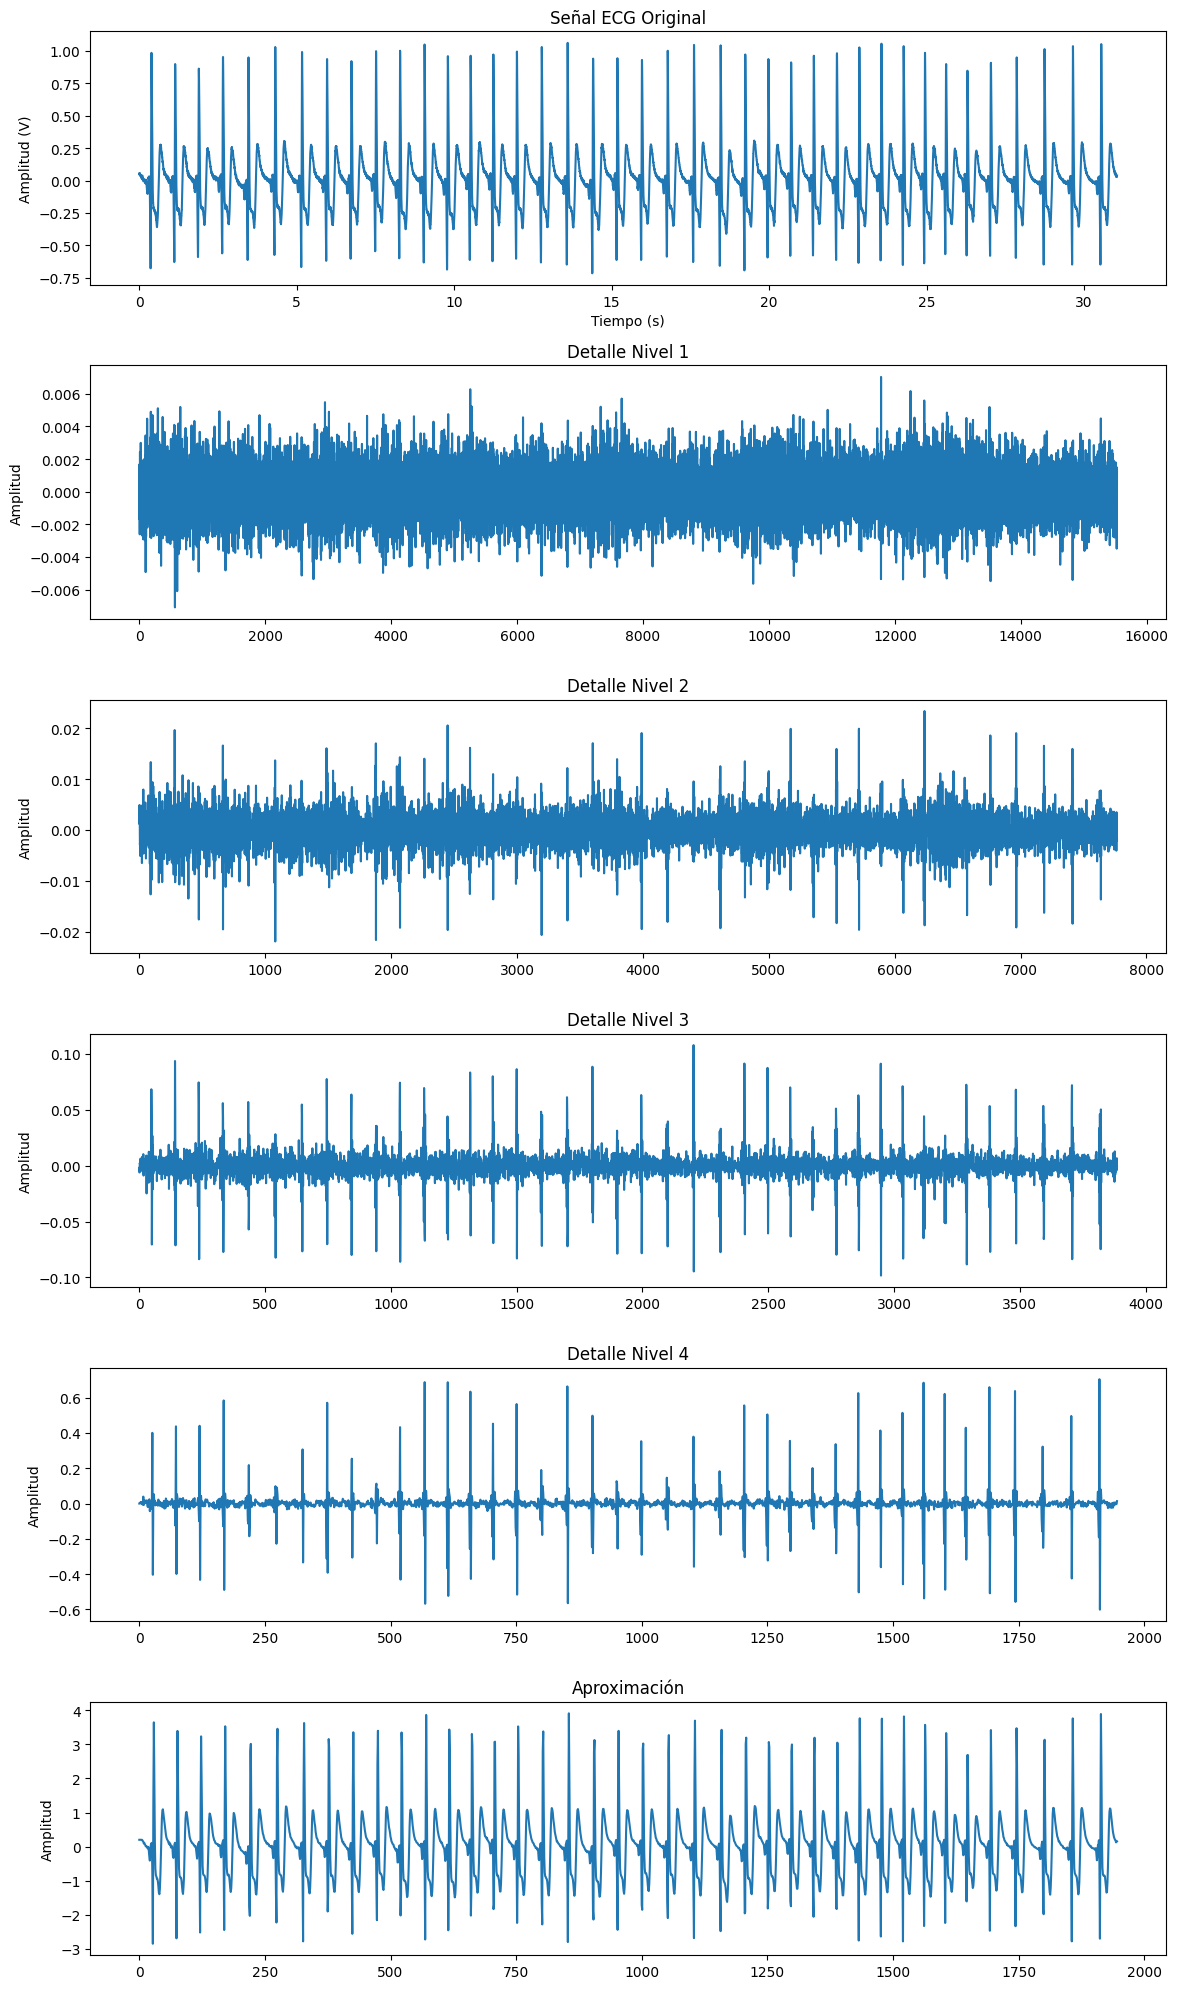

In [39]:

# Aplicar la DWT a señal ECG
niveles = 4
coeficientes = pywt.wavedec(y_1, 'db4', level=niveles)

# Graficar la señal original y los coeficientes de detalle y de aproximación
plt.figure(figsize=(12, 20))

# Graficar la señal original
plt.subplot(niveles + 2, 1, 1)
plt.plot(t_1, y_1)
plt.title('Señal ECG Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (V)')

# Graficar los coeficientes de detalle en orden ascendente (del nivel 1 al 8)
for i in range(1, niveles + 1):
    plt.subplot(niveles + 2, 1, i + 1)
    plt.plot(coeficientes[niveles - i + 1])
    plt.title(f'Detalle Nivel {i}')
    plt.ylabel('Amplitud')

# Graficar el coeficiente de aproximación al final
plt.subplot(niveles + 2, 1, niveles + 2)
plt.plot(coeficientes[0])
plt.title('Aproximación')
plt.ylabel('Amplitud')

plt.tight_layout()
plt.show()

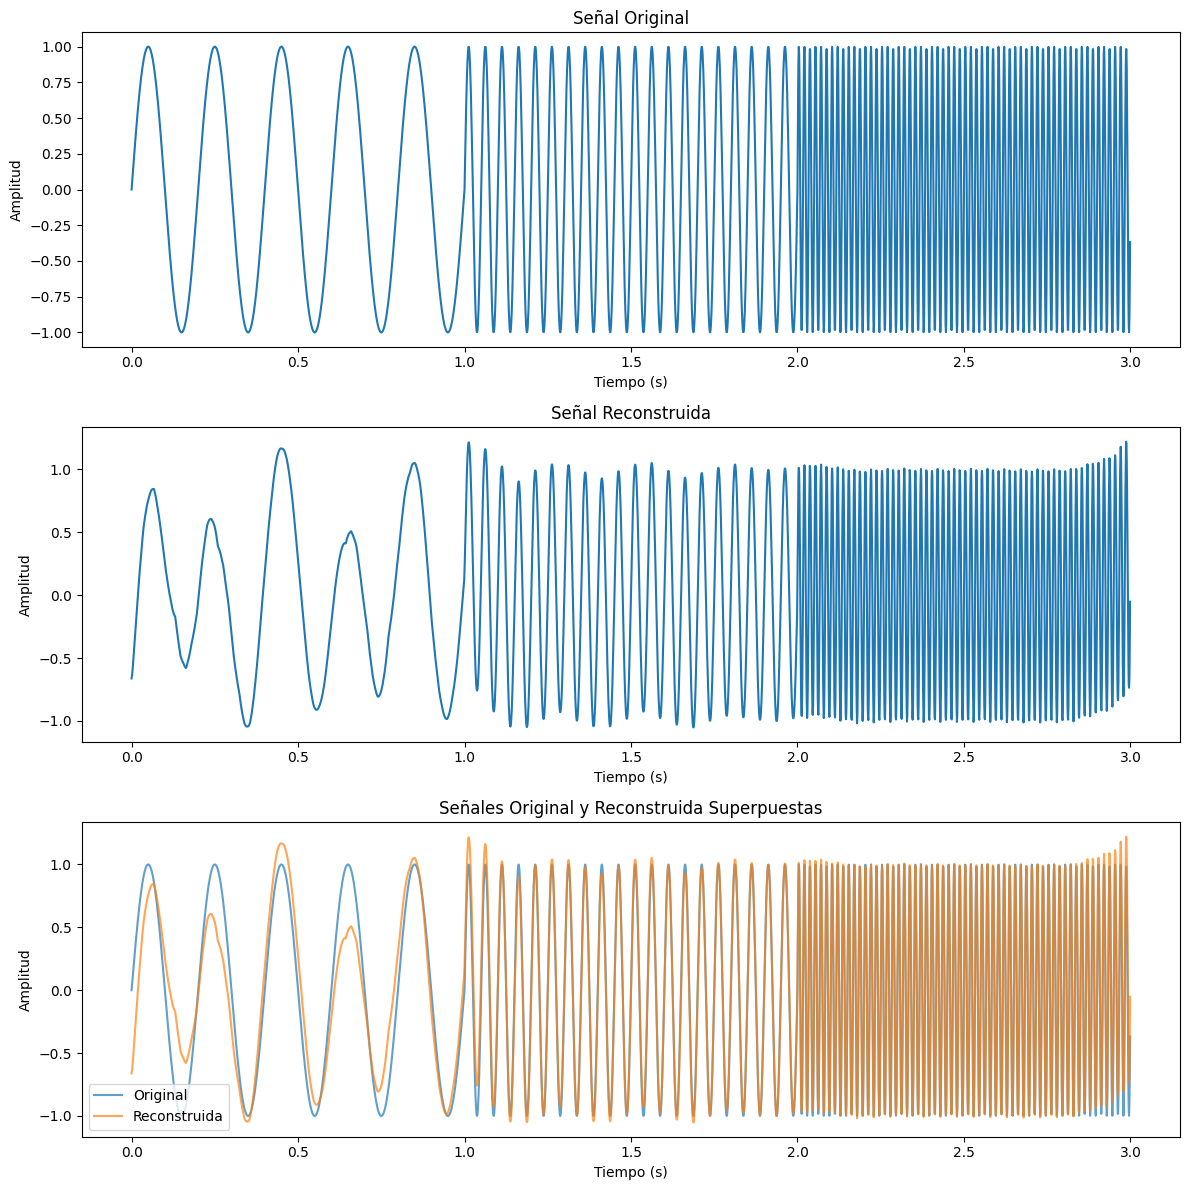

In [33]:

# Crear la figura con tres subplots verticales
plt.figure(figsize=(12, 12))

# Graficar la señal original
plt.subplot(3, 1, 1)  # 3 filas, 1 columna, primer subplot
plt.plot(np.concatenate((t1, t2, t3)), x)
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Graficar la señal reconstruida
plt.subplot(3, 1, 2)  # 3 filas, 1 columna, segundo subplot
plt.plot(np.concatenate((t1, t2, t3)), x_rec)
plt.title('Señal Reconstruida')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Graficar ambas señales superpuestas
plt.subplot(3, 1, 3)  # 3 filas, 1 columna, tercer subplot
plt.plot(np.concatenate((t1, t2, t3)), x, label='Original', alpha=0.7)
plt.plot(np.concatenate((t1, t2, t3)), x_rec, label='Reconstruida', alpha=0.7)
plt.title('Señales Original y Reconstruida Superpuestas')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

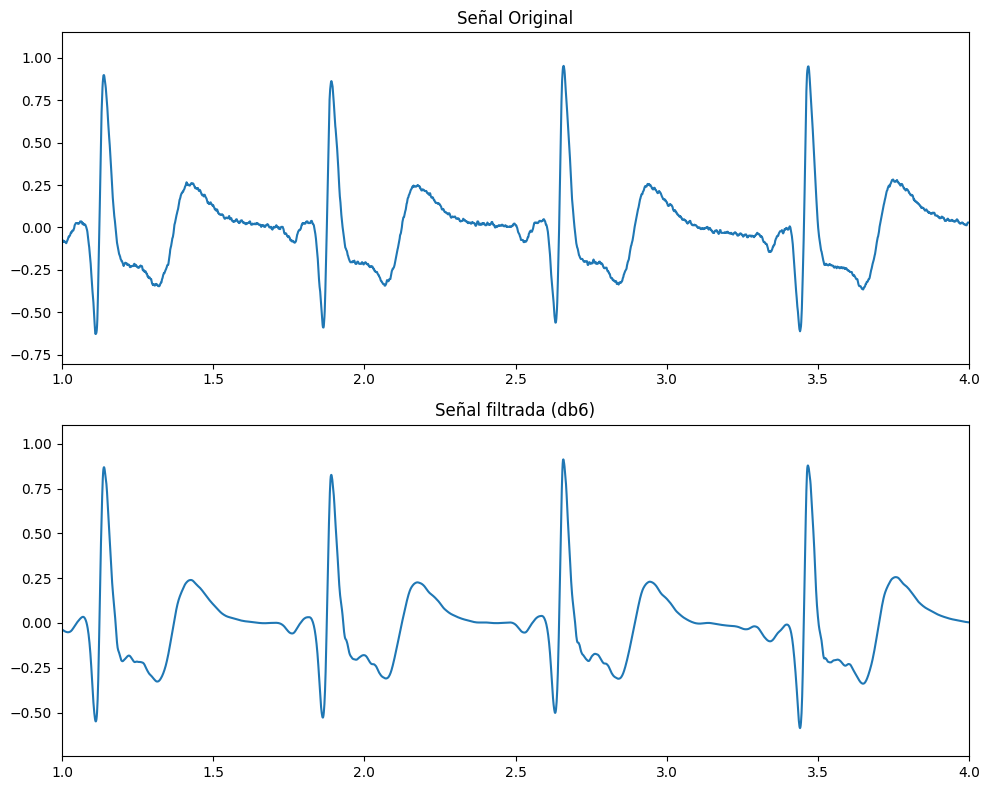

In [34]:
import pywt
import matplotlib.pyplot as plt


# Realizar la descomposición en wavelets
coeffs = pywt.wavedec(y_1, 'db6', level=5)

# Establecer un umbral para el denoising
umbral = 0.1

# Aplicar el umbral a los coeficientes
coeffs_umbral = [pywt.threshold(c, umbral, mode='soft') for c in coeffs]

# Reconstruir la señal denoised
senal_denoised = pywt.waverec(coeffs_umbral, 'db6')

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(t_1, y_1, label='Señal Original')
plt.xlim(1,4)
plt.title('Señal Original')

plt.subplot(2, 1, 2)
plt.plot(t_1, senal_denoised, label='Señal Denoised')
plt.xlim(1,4)
plt.title('Señal filtrada (db6)')

plt.tight_layout()
plt.show()



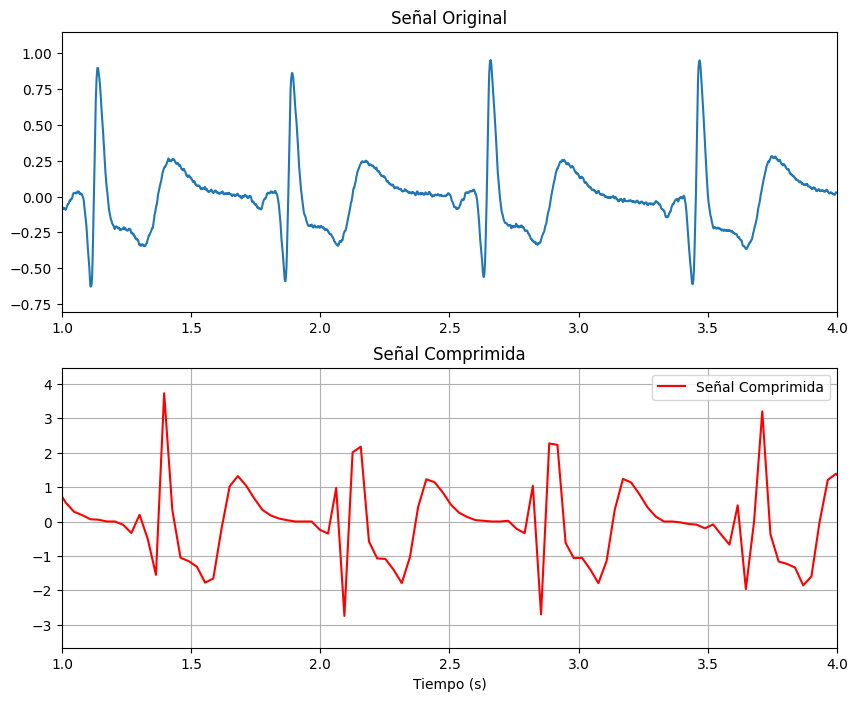

In [35]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que tienes definidos t_1 y y_1
# Obtener los coeficientes de aproximación
coef_aproximacion = coeffs_umbral[0]

# Reconstruir la señal comprimida
senal_comprimida = pywt.waverec([coef_aproximacion], 'db6')

# Obtener el tiempo correspondiente a los datos
t_2 = np.linspace(0, len(y_1)/1000, len(senal_comprimida))  # Suponiendo que la frecuencia de muestreo es 1000 Hz

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(t_1, y_1, label='Señal Original')
plt.xlim(1,4)
plt.title('Señal Original')


plt.subplot(2, 1, 2)
plt.plot(t_2, senal_comprimida, label='Señal Comprimida', color='red')
plt.xlim(1,4)
plt.title('Señal Comprimida')
plt.xlabel('Tiempo (s)')

plt.legend()
plt.grid(True)
plt.show()

